In [3]:
from paths import DATA_DIR, CKPT_FOLDER, PROJECT_FOLDER

import matplotlib.pyplot as plt
import numpy as np
import torch
import scanpy as sc
import scvelo as scv
import cellrank as cr

import scipy
import anndata
import pandas as pd
import seaborn as sns

from torchdyn.core import NeuralODE

from scCFM.datamodules.time_sc_datamodule import TrajectoryDataModule
from scCFM.models.cfm.components.mlp import MLP
from scCFM.models.cfm.cfm_module import CFMLitModule
from scCFM.models.base.vae import VAE
from scCFM.models.base.geometric_vae import GeometricNBVAE
from scCFM.datamodules.sc_datamodule import scDataModule
from scCFM.models.cfm.components.eval.distribution_distances import compute_distribution_distances

from notebooks.utils import (standardize_adata,
                             add_keys_to_dict,
                             real_reconstructed_cells_adata,
                             add_velocity_to_adata, 
                             compute_velocity_projection, 
                             compute_trajectory, 
                             decode_trajectory)


In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
CLUSTER_ANNOTATIONS = {"7": "ESC",
                      "4": "NE-1",
                      "8": "NE-2",
                      "1": "NP",
                      "10": "NS",
                      "3": "NC",
                      "12": "NS-3",
                      "9": "EC-1",
                      "11": "H",
                      "2": "SMP",
                      "0": "LP-ME",
                      "5": "CP", 
                      "13": "PRE-NE",
                      "6": "EN"
                     }

## Util functions

In [6]:
adata_latent_vae = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_lib.h5ad")
adata_latent_flat = sc.read_h5ad(DATA_DIR / "eb" / "flat" / "eb_flat_lib.h5ad")

In [7]:
def get_trajectory_time(adata, cluster, gene_list, n_x0, n_tp=4):
    """
    Starting from cells at later time point with a certain cell type, we trace back to previous time points 
    """
    # Get cells for a certain condition at last time 
    condition = np.logical_and(adata.obs.leiden==cluster, adata.obs.experimental_time==1.0)
    cells_t1 = np.array(adata[condition].obs.index).astype(np.int32) 

    # Collect the indices of the observations mapping to cluster at final time point 
    indices_lineage = [cells_t1]

    # Go back in time and collect cells at previous time points 
    tmp_indices = cells_t1.copy()
    for _ in range(n_tp):
        tmp_indices -= n_x0
        indices_lineage.append(tmp_indices.copy())

    # Collect observations mapping to lineage 
    X_lineage = []
    for idxs in indices_lineage[::-1]:
        X_lineage.append(adata.X[idxs])
    X_lineage = np.stack(X_lineage, axis=1)

    # Collect indices of genes of interest
    gene_to_id = {}
    list_genes = list(adata.var.gene_name)
    for gene in gene_list:
        gene_to_id[gene] = list_genes.index(gene)
    return X_lineage,gene_to_id

def get_trajectory_condition(adata, cluster, gene_list, n_x0, idx2time, n_tp=4):
    """
    Starting from cells of a certain cell type, we trace back to previous time points 
    """
    # Take cell from a cluster 
    condition = adata.obs.leiden==cluster
    cells_condition = adata[condition]
    indices_cells_condition = np.array(cells_condition.obs.index).astype(np.int32) 
    
    # Collect the indices of the observations mapping to cell type
    indices_lineage = [indices_cells_condition]

    # Loop over ts and collect observations
    for t in range(n_tp, 0, -1):
        t = idx2time[t]
        indices_cells_condition_t = np.array(cells_condition[cells_condition.obs.experimental_time==t].obs.index).astype(np.int32)
        tmp_indices = indices_cells_condition_t - n_x0
        indices_lineage.append(tmp_indices.copy())
        cells_condition = adata[np.concatenate(indices_lineage)]

    indices_lineage = np.concatenate(indices_lineage)
    adata_lineage = adata[indices_lineage]

    # Collect indices of genes of interest
    gene_to_id = {}
    list_genes = list(adata.var.gene_name)
    for gene in gene_list:
        gene_to_id[gene] = list_genes.index(gene)
    return adata_lineage, gene_to_id


def plot_violin_time(X_method_list, X_original, data_times, idx2time, method_names, idx, gene_name):
    """
    Violinplot with time on the x-axis and gene expression on the y-axis
    """
    # Append name real data
    method_names.append("real_data")
    # Get the associated time
    real_times = [idx2time[i] for i in idx2time]
    cond = [real_times*X.shape[0] for X in X_method_list]
    cond.append(data_times)
    # Subset to values of interest
    X_list = [X[:,:,idx].ravel() for X in X_method_list]
    X_list.append(X_original[:, idx])
    # Method 
    method = [[method_names[i]]*X_list[i].shape[0] for i in range(len(X_list))]

    # Concatenate
    X_list = np.concatenate(X_list)
    cond = np.concatenate(cond)
    method = np.concatenate(method)
    
    # Create a violin plot
    plt.figure(figsize=(8, 3))
    plotting_dict = {"gene_expression": X_list, 
                     "cond": cond,
                     "method": method}
    
    # sns.boxplot(data=plotting_dict, x="cond", y="gene_expression", hue="method",palette=custom_palette)
    # Plot the orbital period with horizontal boxes
    sns.violinplot(x="cond", y="gene_expression", hue="method", data=plotting_dict,
                whis=[0, 100],width=0.8, palette="vlag", showfliers = False)
    # sns.lmplot(x="cond", y="gene_expression", hue="method", hue_order=["NB-VAE", "Flat NB-VAE", "Real"], data=plotting_dict,
    #              palette="colorblind")
    
    # Add in points to show each observation
    sns.stripplot(x="cond", y="gene_expression", hue="method", data=plotting_dict,
                  size=4, color=".3", linewidth=0, dodge=0.2, legend=False)
    
    # Move the legend to the right outside of the plot
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    plt.ylabel("Gene expression")
    plt.xlabel("Time")
    plt.title(gene_name)
    plt.show()

def plot_violin_condition(anndata_list, gene_name, idx, methods):
    """
    Cell types on the x axis and gene expression on the y-axis
    """
    # Extract Leiden cluster assignments from each anndata object
    leiden_clusters = [adata.obs['leiden'] for adata in anndata_list]
    
    # Extract gene expression data
    gene_expression = []
    for adata in anndata_list:
        try:
            gene_expression.append(adata[:, idx].X.ravel())
        except:
            gene_expression.append(adata[:, idx].X.A.ravel())
    
    # Method names
    methods_names = []
    for i, method_name in enumerate(methods):
        methods_names += [method_name for _ in range(len(gene_expression[i]))]
    
    # Concatenate data
    leiden_clusters = np.concatenate(leiden_clusters)
    gene_expression = np.concatenate(gene_expression)
    method = np.array(methods_names)
    
    # Create a violin plot
    plt.figure(figsize=(8, 3))
    plotting_dict = {"gene_expression": gene_expression, 
                     "leiden_clusters": leiden_clusters,
                     "method": method}
 
    plotting_dict["leiden_clusters"] = [CLUSTER_ANNOTATIONS[i] for i in plotting_dict["leiden_clusters"]]
    
    ax = sns.violinplot(x="leiden_clusters", y="gene_expression", hue="method", data=plotting_dict,
                whis=[40, 60], width=0.8, palette="vlag", showfliers=False, hue_order=["NB-VAE", "Flat NB-VAE", "Real"])
    # ax = sns.barplot(x="leiden_clusters", y="gene_expression", hue="method", data=plotting_dict,
    #             palette="colorblind", hue_order=["NB-VAE", "Flat NB-VAE", "Real"])

    # Add in points to show each observation
    sns.stripplot(x="leiden_clusters", y="gene_expression", hue="method", data=plotting_dict,
                  size=4, color=".3", linewidth=0, dodge=0.2, legend=False)

    plt.ylabel("log(GEX)")
    plt.xlabel("cell type")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(gene_name)
    plt.show()

# Analysis

Initialize datamodule

In [8]:
datamodule_kwargs_vae = {'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/flat/eb_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                          'model_library_size': True}

datamodule_kwargs_flat = {'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/flat/eb_flat_lib.h5ad',
                          'x_layer': 'X_latents',
                          'time_key': 'experimental_time', 
                          'use_pca': False, 
                          'n_dimensions': None, 
                          'train_val_test_split': [0.9, 0.1], 
                          'num_workers': 2, 
                          'batch_size': 512, 
                           'model_library_size': True}

# Initialize the datamodules 
datamodule_vae = TrajectoryDataModule(**datamodule_kwargs_vae)
datamodule_flat = TrajectoryDataModule(**datamodule_kwargs_flat)

# Mapping real times to index
idx2time = datamodule_vae.idx2time

In [9]:
net_hparams = {"dim": datamodule_vae.dim,
                "w": 64,
                "time_varying": True}

net_vae = MLP(**net_hparams).to(device)
net_flat = MLP(**net_hparams).to(device)

CFM model 

In [10]:
cfm_kwargs = {'ot_sampler': 'exact', 
                   'sigma': 0.1, 
                   'use_real_time': False, 
                   'lr': 0.001, 
                   'antithetic_time_sampling': True}

cfm_vae = CFMLitModule(net=net_vae, datamodule=datamodule_vae, **cfm_kwargs).to(device)
cfm_flat = CFMLitModule(net=net_flat, datamodule=datamodule_flat, **cfm_kwargs).to(device)

In [12]:
cfm_vae.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb" / "best_cfm_model_eb.ckpt")["state_dict"])
cfm_flat.load_state_dict(torch.load(CKPT_FOLDER / "trajectory" / "eb" / "best_cfm_model_flat_eb.ckpt")["state_dict"])

<All keys matched successfully>

**Decoded trajectories**

In [13]:
datamodule={'path': '/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad', 
            'x_layer': 'X_norm', 
            'cond_keys': ['experimental_time', 'leiden'],
            'use_pca': False, 
            'n_dimensions': None, 
            'train_val_test_split': [1], 
            'batch_size': 512, 
            'num_workers': 2}

# Initialize datamodule
datamodule = scDataModule(**datamodule)

Initialize variational autoencoders

In [14]:
model_vae={
       'in_dim': datamodule.in_dim,
       'n_epochs_anneal_kl': 1000, 
       'kl_weight': None, 
       'likelihood': 'nb', 
       'dropout': False, 
       'learning_rate': 0.001, 
       'dropout_p': False, 
       'model_library_size': True, 
       'batch_norm': True, 
       'kl_warmup_fraction': 0.1, 
       'hidden_dims': [256, 10]}
        
geometric={'compute_metrics_every': 1, 
           'use_c': True, 
           'l2': True, 
           'eta_interp': 0, 
           'interpolate_z': False, 
           'start_jac_after': 0, 
           'fl_weight': 0.1,
           'detach_theta': True}

In [15]:
# Initialize vae and geometric vae
vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).to(cfm_vae.device)
geometric_vae = GeometricNBVAE(**geometric, vae_kwargs=model_vae).to(cfm_vae.device)

In [16]:
# Load state dicts and put in eval mode 
vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_vae_lib.ckpt")["state_dict"])
geometric_vae.load_state_dict(torch.load(PROJECT_FOLDER / "checkpoints/ae/eb/best_model_geometric_lib.ckpt")["state_dict"])

vae.eval()
geometric_vae.eval()

GeometricNBVAE(
  (encoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=1241, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (decoder_layers): MLP(
    (net): Sequential(
      (0): Sequential(
        (0): Linear(in_features=10, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ELU(alpha=1.0)
      )
    )
  )
  (library_size_decoder): Linear(in_features=10, out_features=1, bias=True)
  (decoder_mu_lib): Linear(in_features=256, out_features=1241, bias=True)
  (mu_logvar): Linear(in_features=256, out_features=20, bias=True)
)

Compute the trajectories 

In [17]:
#Pick time 0 observations
X_adata_t0_vae = torch.from_numpy(adata_latent_vae[adata_latent_vae.obs["experimental_time"]==0].X).to(device)
X_adata_t0_flat = torch.from_numpy(adata_latent_flat[adata_latent_flat.obs["experimental_time"]==0].X).to(device)

#Library values of observations at time 0
l_t0_vae = adata_latent_vae.obs.loc[adata_latent_vae.obs["experimental_time"]==0, "log_library_size"].to_numpy()
l_t0_flat = adata_latent_flat.obs.loc[adata_latent_flat.obs["experimental_time"]==0, "log_library_size"].to_numpy()
l_t0_vae = torch.from_numpy(l_t0_vae).to(device)
l_t0_flat = torch.from_numpy(l_t0_flat).to(device)

In [18]:
# Number of observations at x0
n_x0 = X_adata_t0_vae.shape[0]

In [19]:
# Collect data trajectories
mu_traj_vae, x_traj_vae, times_traj_vae = decode_trajectory(X_adata_t0_vae,
                                                            l_t0_vae,
                                                            cfm_vae,
                                                            vae,
                                                            idx2time, 
                                                            device, 
                                                            use_real_time=False,
                                                            append_last=True,
                                                            keep_time_d=False)

mu_traj_flat, x_traj_flat, times_traj_flat = decode_trajectory(X_adata_t0_flat,
                                                               l_t0_flat,
                                                               cfm_flat,
                                                               geometric_vae,
                                                               idx2time, 
                                                               device, 
                                                               use_real_time=False, 
                                                               append_last=True,
                                                               keep_time_d=False)

# Real time cells (for plotting)
times_traj_vae = pd.DataFrame(times_traj_vae)
times_traj_flat = pd.DataFrame(times_traj_flat)

times_traj_vae.columns = ["experimental_time"]
times_traj_flat.columns = ["experimental_time"]

In [20]:
# Create anndatas
adata_x_traj_vae = anndata.AnnData(X=x_traj_vae.detach().numpy(), 
                                     obs=times_traj_vae)
adata_x_traj_flat = anndata.AnnData(X=x_traj_flat.detach().numpy(),
                                      obs=times_traj_flat)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


We now have simulated datasets. We read the true datasets and visualize it 

In [21]:
adata_eb_original = sc.read_h5ad('/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/eb_phate.h5ad')

Annotate genes

In [22]:
adata_x_traj_vae.var = adata_eb_original.var.copy()
adata_x_traj_flat.var = adata_eb_original.var.copy()

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


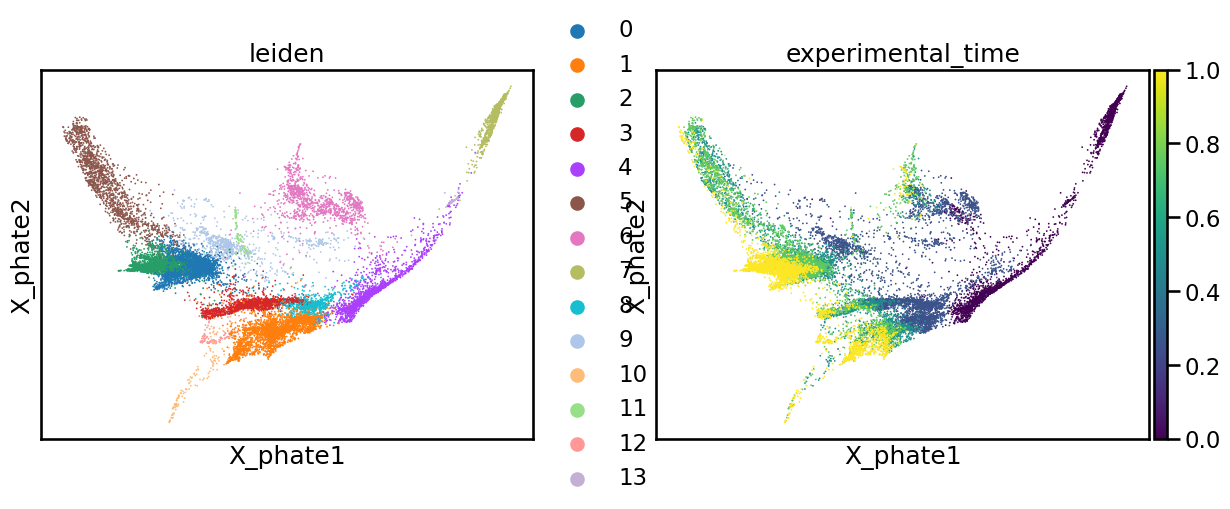

In [23]:
sc.pl.embedding(adata_eb_original, basis="X_phate", color=["leiden", "experimental_time"])

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


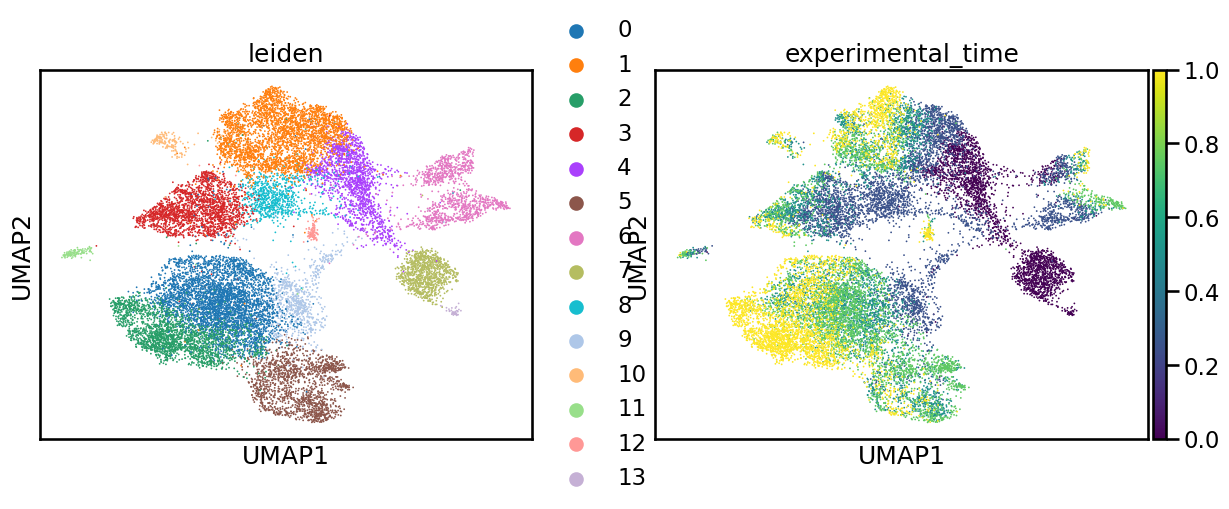

In [24]:
sc.pl.umap(adata_eb_original, color=["leiden", "experimental_time"])

In [25]:
#log1p and neighbors calculation
sc.pp.log1p(adata_x_traj_vae)
sc.pp.log1p(adata_x_traj_flat)

sc.tl.pca(adata_x_traj_vae)
sc.tl.pca(adata_x_traj_flat)

sc.pp.neighbors(adata_x_traj_vae)
sc.pp.neighbors(adata_x_traj_flat)

sc.tl.umap(adata_x_traj_vae)
sc.tl.umap(adata_x_traj_flat)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10

In [26]:
# Transfer labels from the data to the simulated cells 
sc.tl.ingest(adata_x_traj_vae, adata_eb_original, obs="leiden", embedding_method="umap")
sc.tl.ingest(adata_x_traj_flat, adata_eb_original, obs="leiden", embedding_method="umap")

In [81]:
adata_x_traj_flat.write_h5ad("/nfs/homedirs/pala/scCFM/project_dir/data/eb/processed/generated_counts_flatvi.h5ad")

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


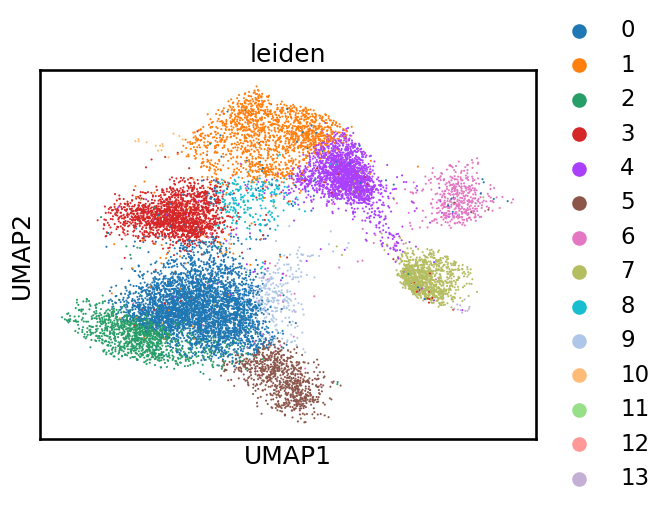

In [27]:
sc.pl.umap(adata_x_traj_flat, color="leiden")

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


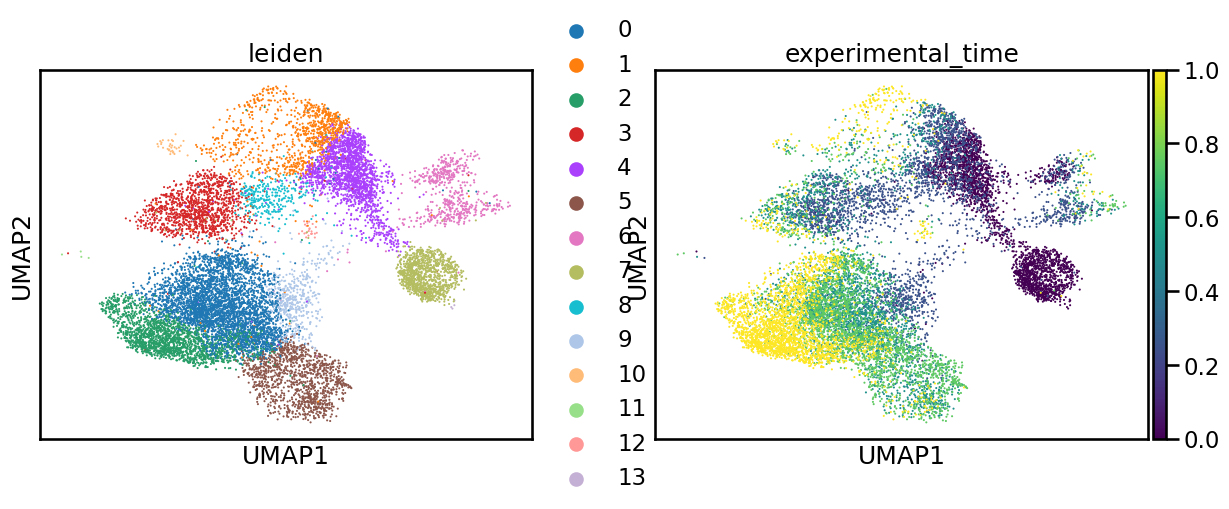

In [28]:
sc.pl.umap(adata_x_traj_vae, color=["leiden", "experimental_time"])

In [29]:
# Reset indices 
adata_x_traj_flat.var = adata_x_traj_flat.var.reset_index()
adata_x_traj_vae.var = adata_x_traj_vae.var.reset_index()
adata_eb_original.var = adata_eb_original.var.reset_index()

# Perform timepoint analysis

### Neural crest cells

In [30]:
X_neural_crest_cells_flat, genes_neural_crest_cells = get_trajectory_time(adata_x_traj_flat, 
                                                                     '3', 
                                                                     ["NGFR", "GYPC", "CXCR4", "PDGFRB", "HOXA2", "POU5F1"], 
                                                                     n_x0=n_x0,
                                                                     n_tp=4)

X_neural_crest_cells_vae, _ = get_trajectory_time(adata_x_traj_vae, 
                                            '3', 
                                            ["NGFR", "GYPC", "CXCR4", "PDGFRB", "HOXA2", "POU5F1"], 
                                             n_x0=n_x0,
                                             n_tp=4)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


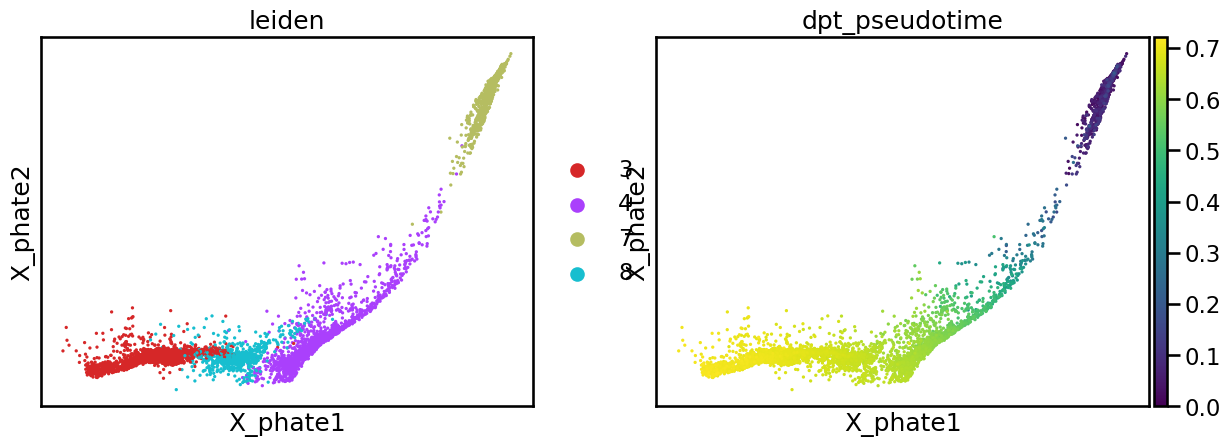

/tmp/ipykernel_555383/1657719037.py:3: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_eb_original_neural_crest.uns['iroot'] = np.flatnonzero(adata_eb_original_neural_crest.obs['leiden']  == '7')[0]
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [31]:
adata_eb_original_neural_crest = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '4', '8', '3'])]
sc.pl.embedding(adata_eb_original_neural_crest, basis="X_phate", color=["leiden", "dpt_pseudotime"])
adata_eb_original_neural_crest.uns['iroot'] = np.flatnonzero(adata_eb_original_neural_crest.obs['leiden']  == '7')[0]
sc.tl.dpt(adata_eb_original_neural_crest)
adata_eb_original_neural_crest = adata_eb_original_neural_crest[adata_eb_original_neural_crest.obs.sort_values(by="dpt_pseudotime").index]

Plot pseudotime 

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


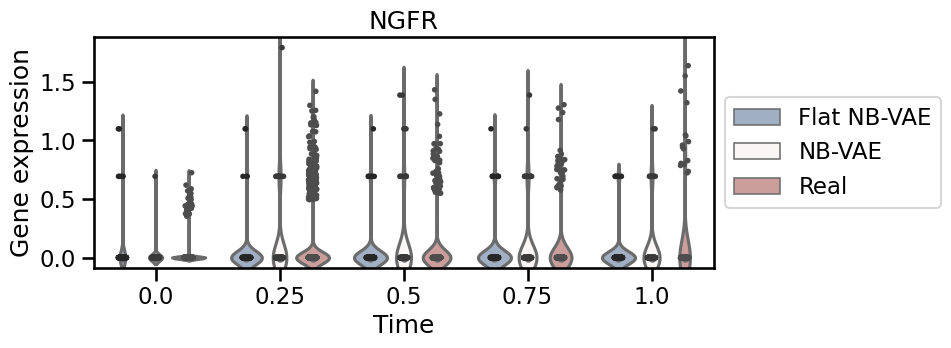

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


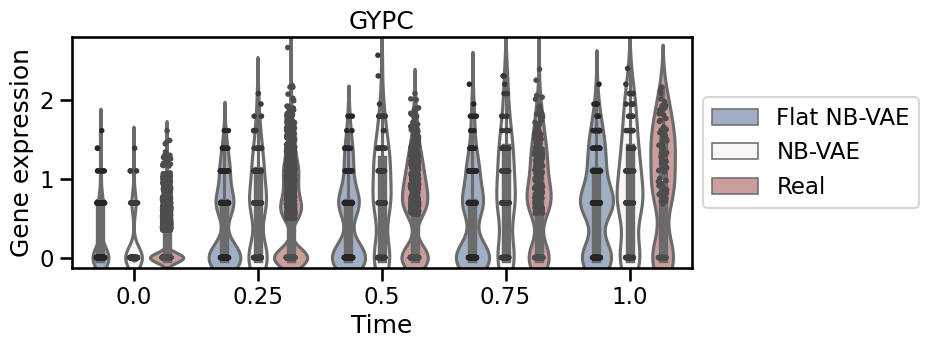

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


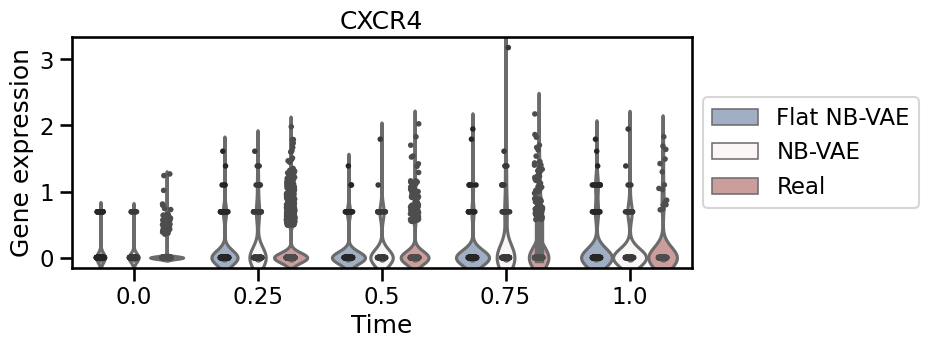

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


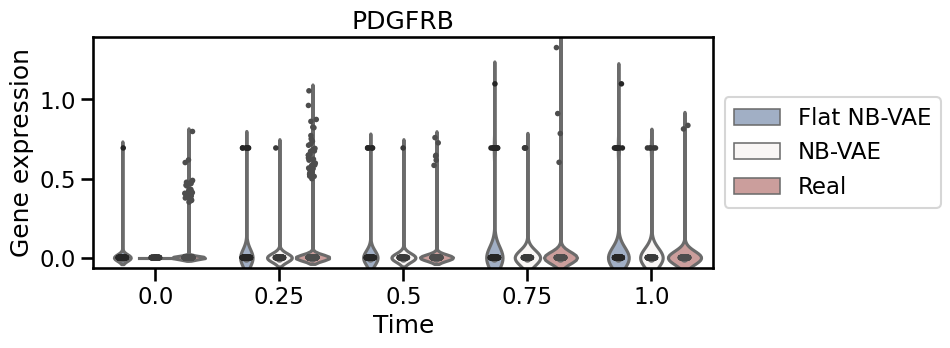

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


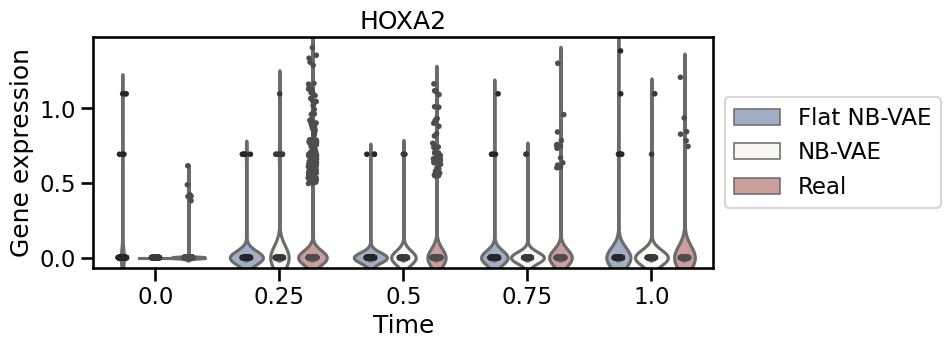

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


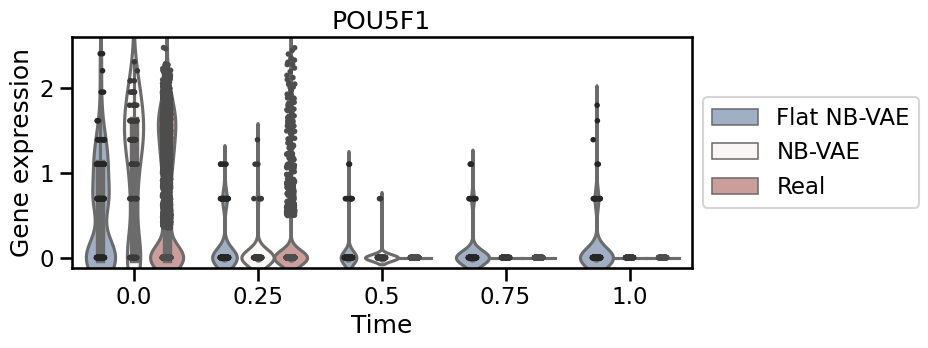

In [32]:
for gene, gene_id in genes_neural_crest_cells.items():
    plot_violin_time([X_neural_crest_cells_flat, X_neural_crest_cells_vae], 
                     np.array(adata_eb_original_neural_crest.layers["X_log"].A), 
                     np.array(adata_eb_original_neural_crest.obs.experimental_time), 
                     idx2time, 
                     ["Flat NB-VAE", "NB-VAE", "Real"],
                     gene_id, 
                     gene)

### Neuronal branch

In [33]:
X_neuronal_flat, genes_neuronal_cells = get_trajectory_time(adata_x_traj_flat, 
                                                              '10', 
                                                              ["LMX1A", "ISL1", "DLX1", "CXCR4", "HOXB1", "NR2F1"], 
                                                              n_x0=n_x0,
                                                              n_tp=4)

X_neuronal_vae, genes_neuronal_cells = get_trajectory_time(adata_x_traj_vae, 
                                                             '10', 
                                                             ["LMX1A", "ISL1", "DLX1", "CXCR4", "HOXB1", "NR2F1"], 
                                                             n_x0=n_x0,
                                                             n_tp=4)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


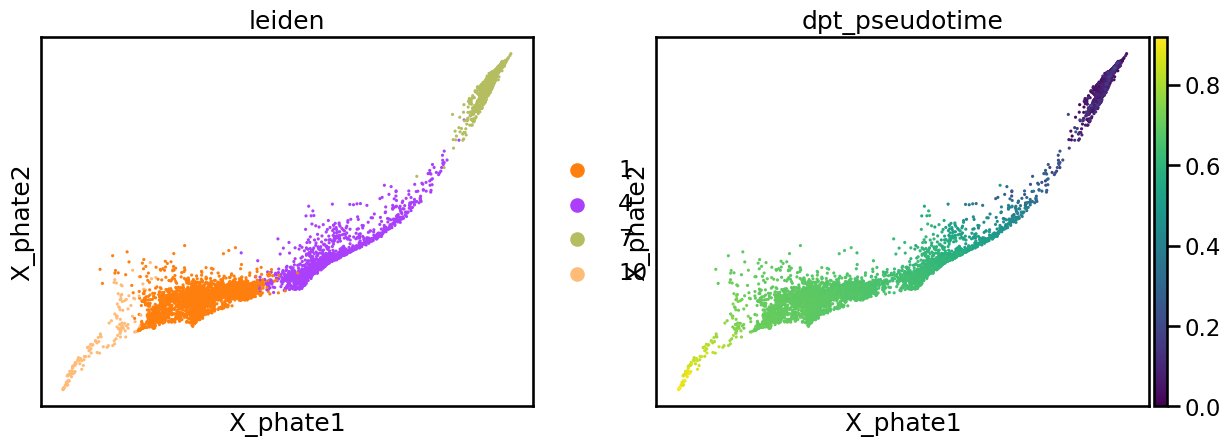

/tmp/ipykernel_555383/4123313004.py:3: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_eb_original_neuronal.uns['iroot'] = np.flatnonzero(adata_eb_original_neural_crest.obs['leiden']  == '7')[0]
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [34]:
adata_eb_original_neuronal = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '4', '1', '10'])]
sc.pl.embedding(adata_eb_original_neuronal, basis="X_phate", color=["leiden", "dpt_pseudotime"])
adata_eb_original_neuronal.uns['iroot'] = np.flatnonzero(adata_eb_original_neural_crest.obs['leiden']  == '7')[0]
sc.tl.dpt(adata_eb_original_neuronal)
adata_eb_original_neuronal = adata_eb_original_neuronal[adata_eb_original_neuronal.obs.sort_values(by="dpt_pseudotime").index]

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


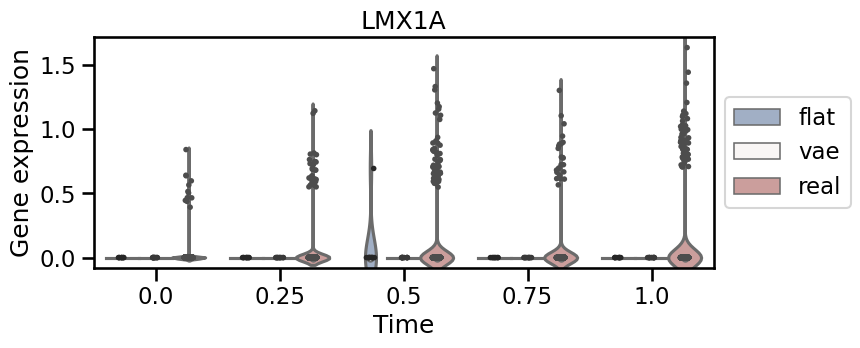

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


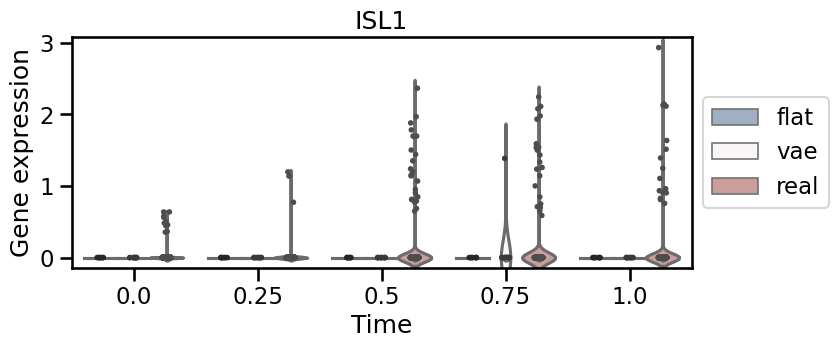

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


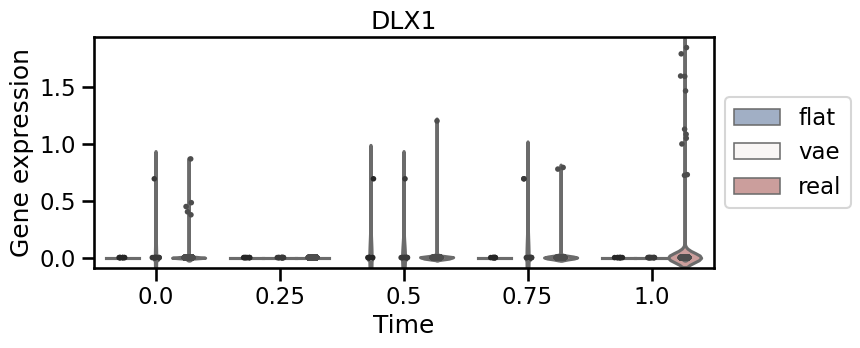

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


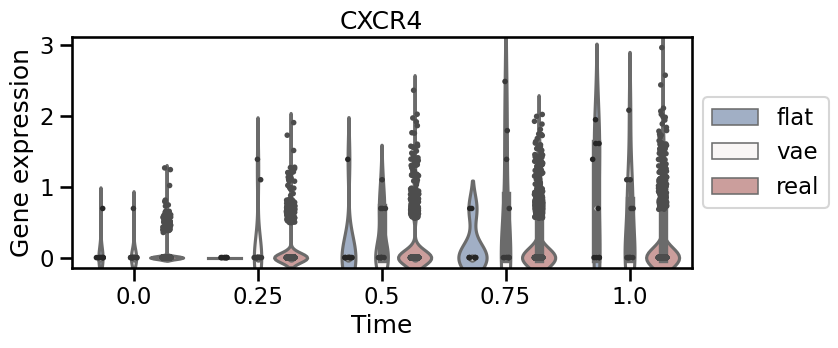

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


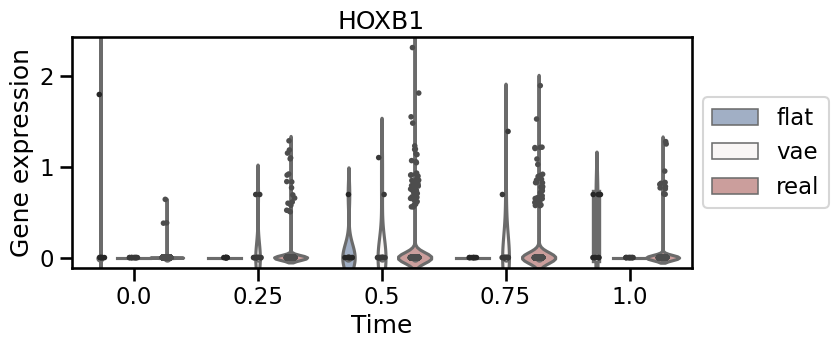

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


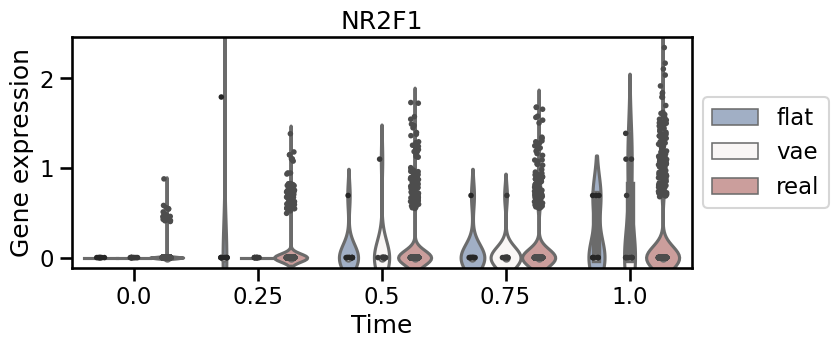

In [35]:
for gene, gene_id in genes_neuronal_cells.items():
    plot_violin_time([X_neuronal_flat, X_neuronal_vae], 
                     np.array(adata_eb_original_neuronal.layers["X_log"].A), 
                     np.array(adata_eb_original_neuronal.obs.experimental_time), 
                     idx2time, 
                     ["flat", "vae", "real"],
                     gene_id, 
                     gene)

### Cardiac branch

In [36]:
X_cardiac_flat, genes_cardiac_cells = get_trajectory_time(adata_x_traj_flat, 
                                                     '5', 
                                                     ["GATA6", "GATA5", "HAND1", "TNNT2"], 
                                                     n_x0=n_x0,
                                                     n_tp=4)

X_cardiac_vae, genes_cardiac_cells = get_trajectory_time(adata_x_traj_vae, 
                                                    '5', 
                                                    ["GATA6", "GATA5", "HAND1", "TNNT2"], 
                                                    n_x0=n_x0,
                                                    n_tp=4)

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


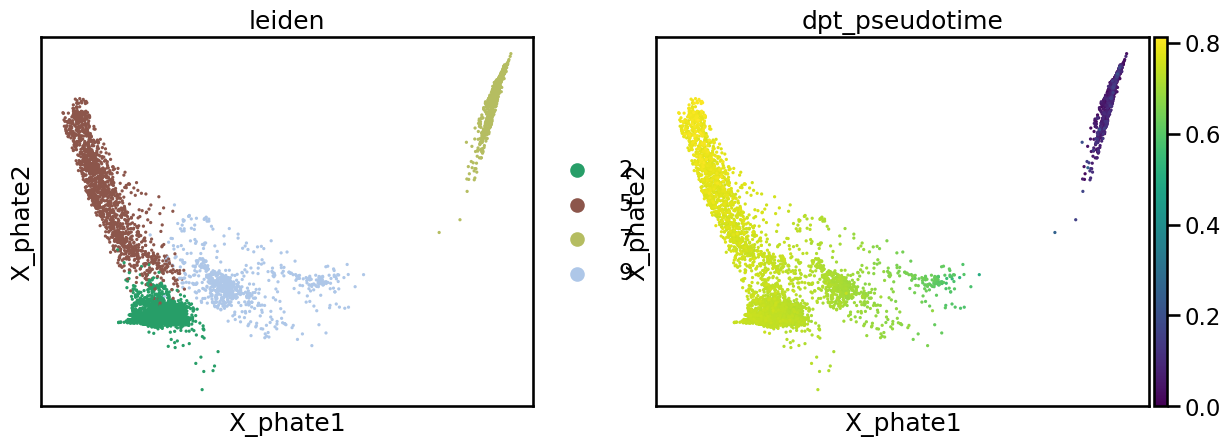

/tmp/ipykernel_555383/715591683.py:3: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_eb_original_cardiac.uns['iroot'] = np.flatnonzero(adata_eb_original_cardiac.obs['leiden']  == '7')[0]
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [37]:
adata_eb_original_cardiac = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '9', '2', '5'])]
sc.pl.embedding(adata_eb_original_cardiac, basis="X_phate", color=["leiden", "dpt_pseudotime"])
adata_eb_original_cardiac.uns['iroot'] = np.flatnonzero(adata_eb_original_cardiac.obs['leiden']  == '7')[0]
sc.tl.dpt(adata_eb_original_cardiac)
adata_eb_original_cardiac = adata_eb_original_cardiac[adata_eb_original_cardiac.obs.sort_values(by="dpt_pseudotime").index]

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


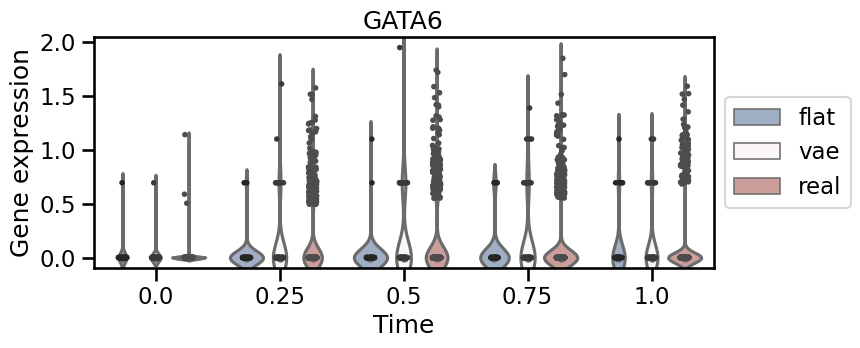

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


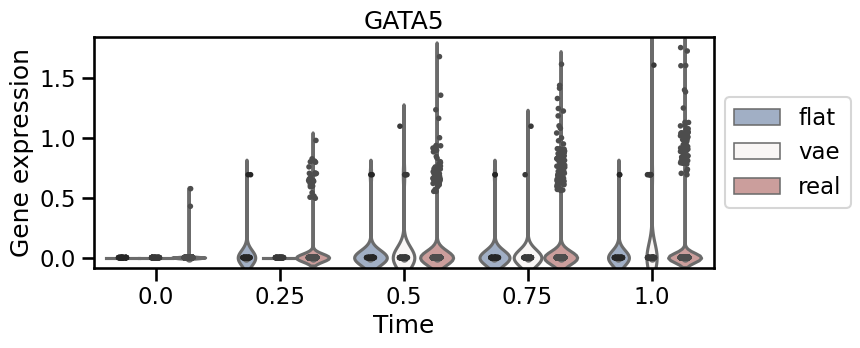

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


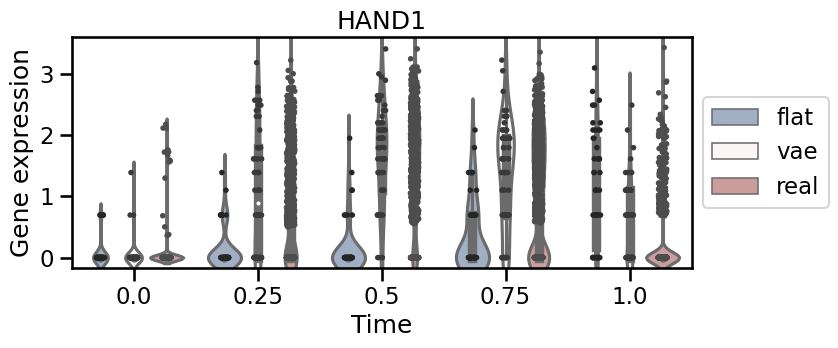

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


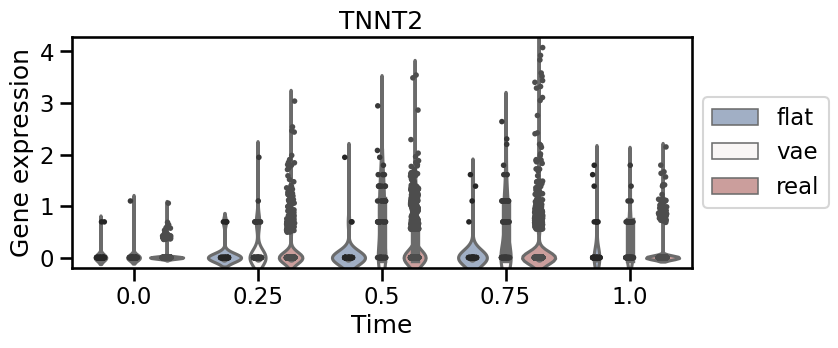

In [38]:
for gene, gene_id in genes_cardiac_cells.items():
    plot_violin_time([X_cardiac_flat, X_cardiac_vae], 
                     np.array(adata_eb_original_cardiac.layers["X_log"].A), 
                     np.array(adata_eb_original_cardiac.obs.experimental_time), 
                     idx2time, 
                     ["flat", "vae", "real"],
                     gene_id, 
                     gene)

# Perform lineage analysis

### Neural crest

In [39]:
X_neural_crest_cells_flat_ct, genes_neural_crest_cells = get_trajectory_condition(adata_x_traj_flat, '3', 
                                                                                  ["NGFR", "GYPC", "CXCR4", "PDGFRB", "HOXA2", "POU5F1"], 
                                                                                  n_x0=n_x0,
                                                                                  idx2time=idx2time,
                                                                                  n_tp=4)
X_neural_crest_cells_flat_ct = X_neural_crest_cells_flat_ct[X_neural_crest_cells_flat_ct.obs.leiden.isin(['7', '4', '8', '3'])]


X_neural_crest_cells_vae_ct, genes_neural_crest_cells = get_trajectory_condition(adata_x_traj_vae, '3', 
                                                                                  ["NGFR", "GYPC", "CXCR4", "PDGFRB", "HOXA2", "POU5F1"], 
                                                                                  n_x0=n_x0,
                                                                                  idx2time=idx2time,
                                                                                  n_tp=4)
X_neural_crest_cells_vae_ct = X_neural_crest_cells_vae_ct[X_neural_crest_cells_vae_ct.obs.leiden.isin(['7', '4', '8', '3'])]

In [40]:
genes_neural_crest_cells

{'NGFR': 755,
 'GYPC': 455,
 'CXCR4': 257,
 'PDGFRB': 824,
 'HOXA2': 496,
 'POU5F1': 876}

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


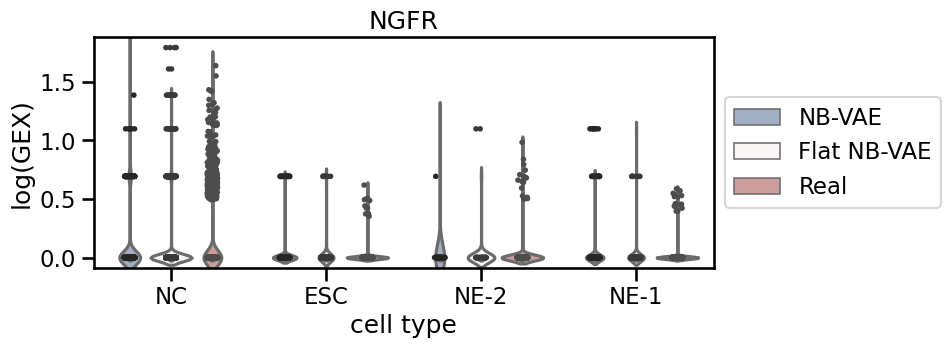

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


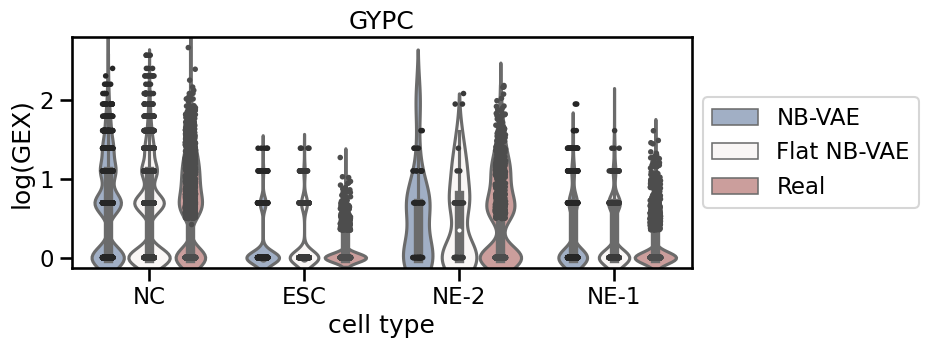

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


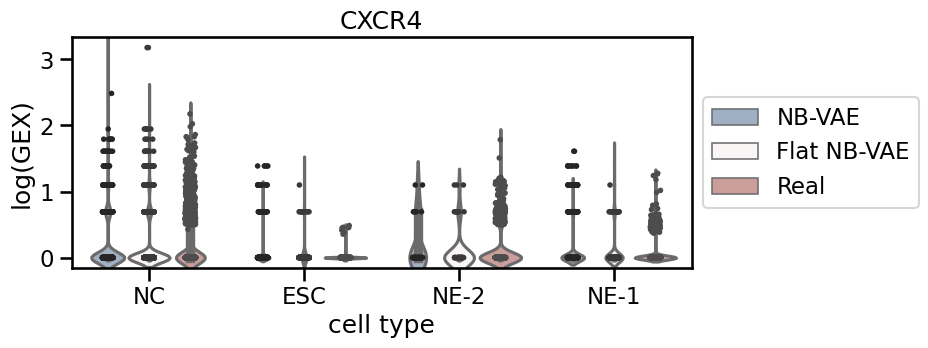

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


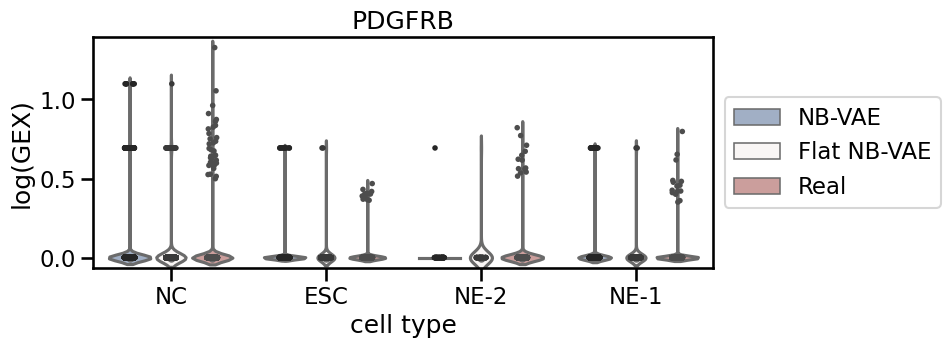

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


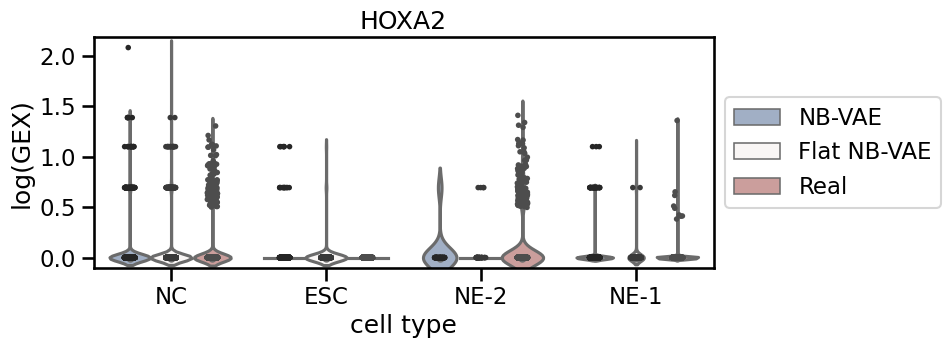

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


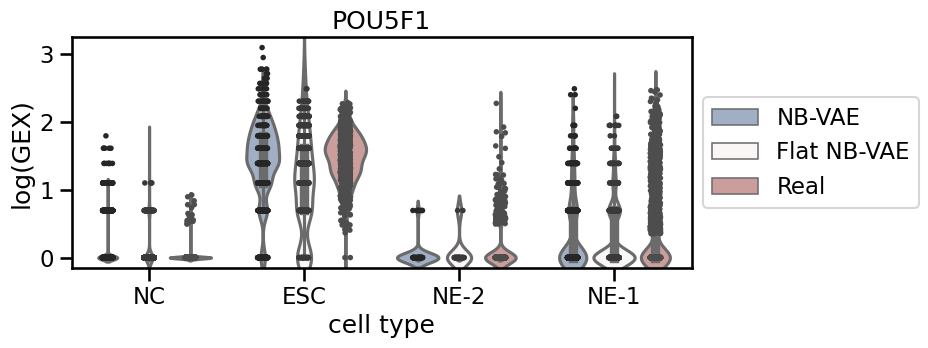

In [41]:
for gene, gene_id in genes_neural_crest_cells.items():
    plot_violin_condition([X_neural_crest_cells_flat_ct, X_neural_crest_cells_vae_ct, adata_eb_original_neural_crest],
                            gene, 
                            gene_id,
                            methods=["Flat NB-VAE", "NB-VAE", "Real"])

In [42]:
scipy.stats.wasserstein_distance(np.array(X_neural_crest_cells_flat_ct[:, 455].X).squeeze(), 
                   np.array(adata_eb_original_neural_crest[:, 455].X.A).squeeze())

0.06163833980760175

In [43]:
scipy.stats.wasserstein_distance(np.array(X_neural_crest_cells_vae_ct[:, 455].X).squeeze(), 
                   np.array(adata_eb_original_neural_crest[:, 455].X.A).squeeze())

0.07535515655336616

### Neuronal

In [44]:
X_neuronal_flat_ct, genes_neuronal_cells = get_trajectory_condition(adata_x_traj_flat, 
                                                                    '10', 
                                                                    ["LMX1A", "ISL1", "DLX1", "CXCR4", "HOXB1","NR2F1"], 
                                                                    n_x0=n_x0,
                                                                    idx2time=idx2time,
                                                                    n_tp=4)
X_neuronal_flat_ct = X_neuronal_flat_ct[X_neuronal_flat_ct.obs.leiden.isin(['7', '4', '1', '10'])]

X_neuronal_vae_ct, genes_neuronal_cells = get_trajectory_condition(adata_x_traj_vae, 
                                                                   '10', 
                                                                    ["LMX1A", "ISL1", "DLX1", "CXCR4", "HOXB1", "NR2F1"],
                                                                    n_x0=n_x0,
                                                                    idx2time=idx2time,
                                                                    n_tp=4)
X_neuronal_vae_ct = X_neuronal_vae_ct[X_neuronal_vae_ct.obs.leiden.isin(['7', '4', '1', '10'])]

In [45]:
genes_neuronal_cells

{'LMX1A': 649,
 'ISL1': 569,
 'DLX1': 282,
 'CXCR4': 257,
 'HOXB1': 503,
 'NR2F1': 775}

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


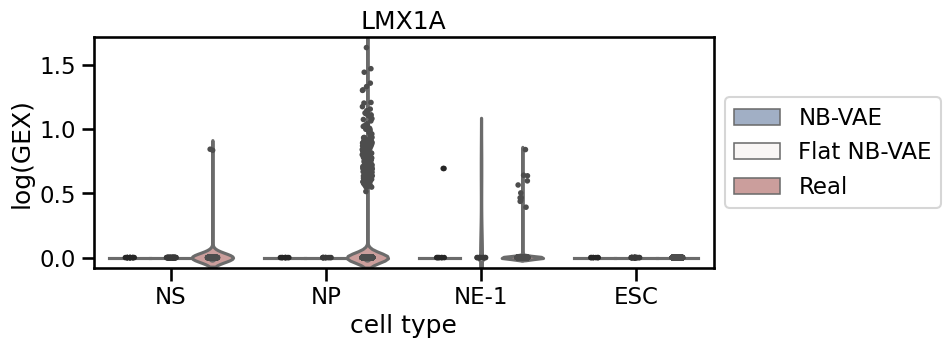

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


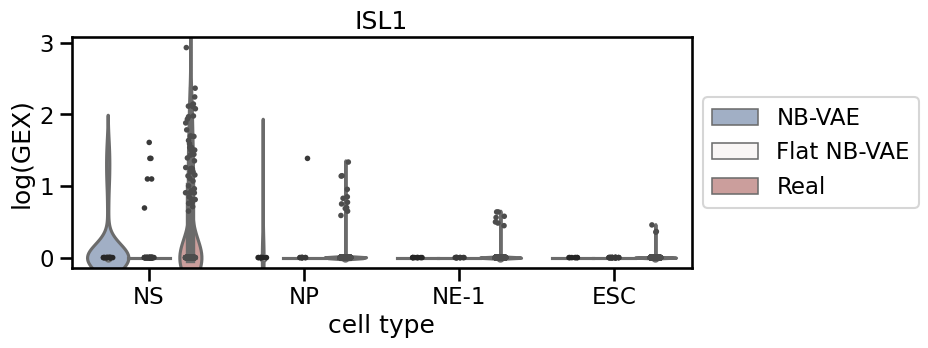

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


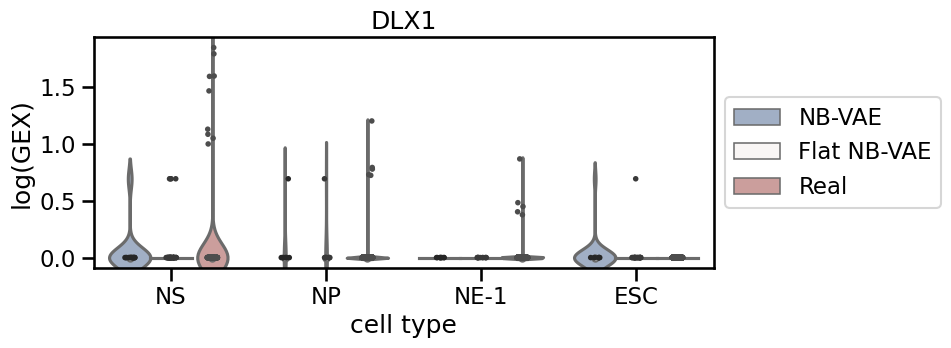

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


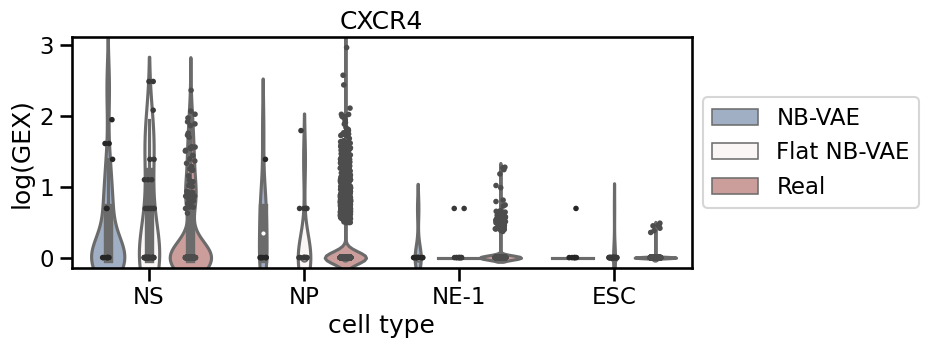

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


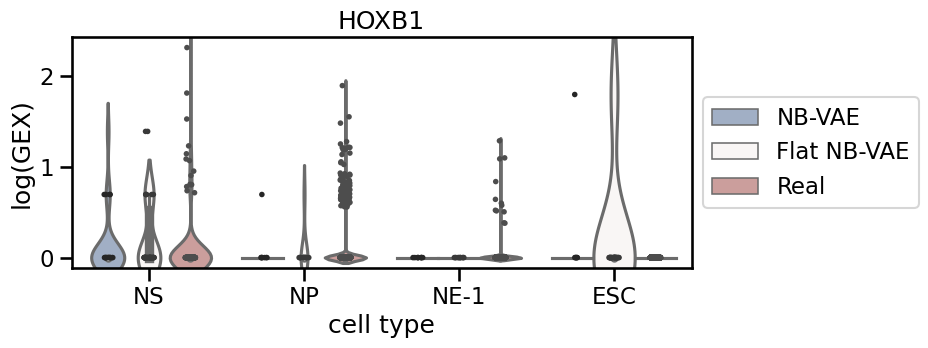

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


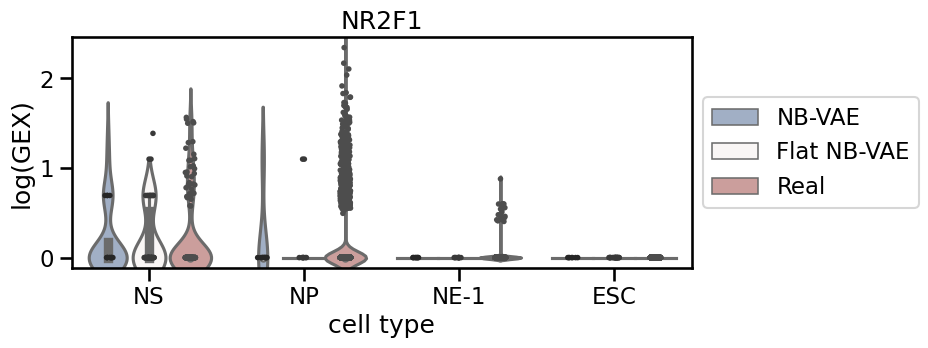

In [46]:
for gene, gene_id in genes_neuronal_cells.items():
    plot_violin_condition([X_neuronal_flat_ct, X_neuronal_vae_ct, adata_eb_original_neuronal],
                            gene, 
                            gene_id,
                            methods=["Flat NB-VAE", "NB-VAE", "Real"])

In [47]:
scipy.stats.wasserstein_distance(np.array(X_neuronal_flat_ct[:, 503].X).squeeze(), 
                   np.array(adata_eb_original_neuronal[:, 503].X.A).squeeze())

0.12128867376868946

In [48]:
scipy.stats.wasserstein_distance(np.array(X_neuronal_vae_ct[:, 503].X).squeeze(), 
                   np.array(adata_eb_original_neuronal[:, 503].X.A).squeeze())

0.04985225669410629

### Cardiac

In [49]:
X_cardiac_flat_ct, genes_cardiac_cells = get_trajectory_condition(adata_x_traj_flat, 
                                                                  '5', 
                                                                  ["GATA6", "GATA5", "HAND1", "TNNT2"], 
                                                                  n_x0=n_x0,
                                                                  idx2time=idx2time,
                                                                  n_tp=4)
X_cardiac_flat_ct = X_cardiac_flat_ct[X_cardiac_flat_ct.obs.leiden.isin(['7', '9', '2', '5'])]

X_cardiac_vae_ct, genes_cardiac_cells = get_trajectory_condition(adata_x_traj_vae,
                                                                 '5', 
                                                                ["GATA6", "GATA5", "HAND1", "TNNT2"],
                                                                n_x0=n_x0,
                                                                idx2time=idx2time,
                                                                n_tp=4)
X_cardiac_vae_ct = X_cardiac_vae_ct[X_cardiac_vae_ct.obs.leiden.isin(['7', '9', '2', '5'])]

In [50]:
genes_cardiac_cells

{'GATA6': 420, 'GATA5': 419, 'HAND1': 459, 'TNNT2': 1153}

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


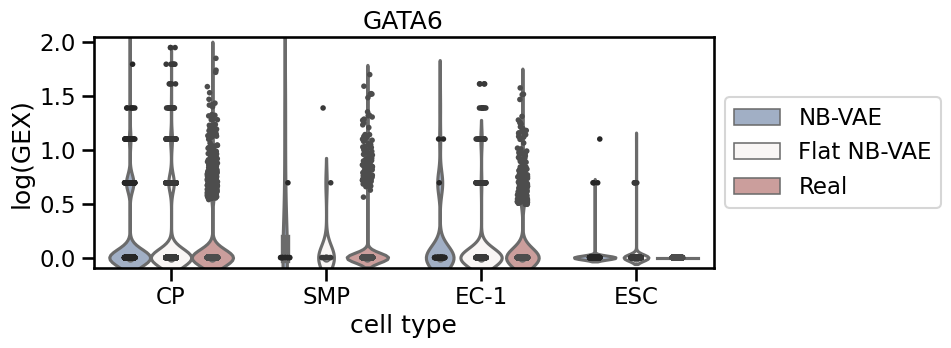

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


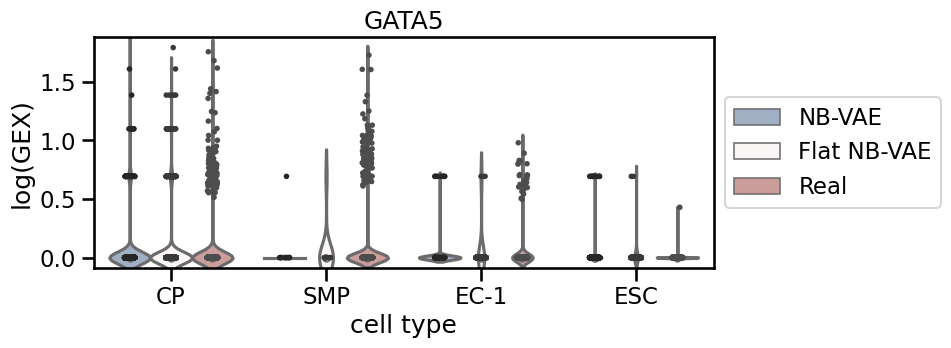

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


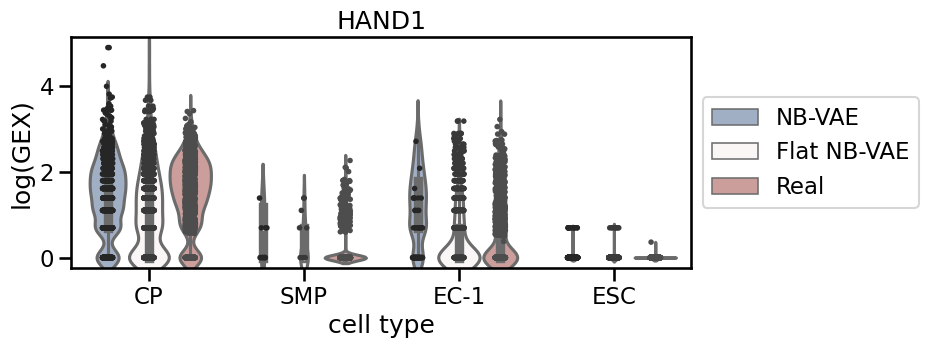

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


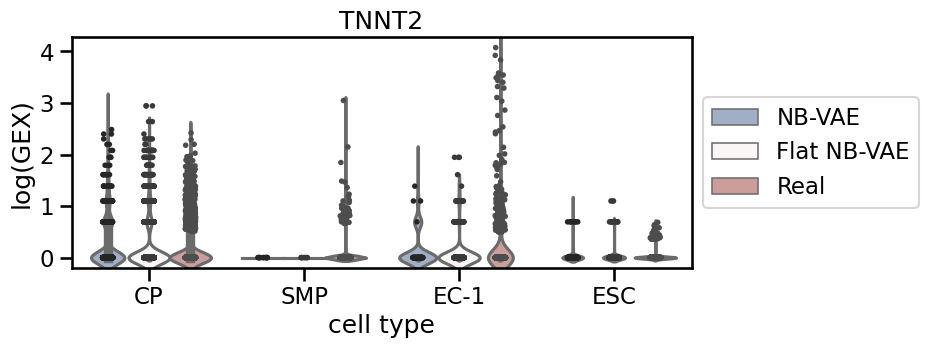

In [51]:
for gene, gene_id in genes_cardiac_cells.items():
    plot_violin_condition([X_cardiac_flat_ct, X_cardiac_vae_ct, adata_eb_original_cardiac],
                            gene, 
                            gene_id,
                            methods=["Flat NB-VAE", "NB-VAE", "Real"])

In [52]:
scipy.stats.wasserstein_distance(np.array(X_cardiac_flat_ct[:, 459].X).squeeze(), 
                   np.array(adata_eb_original_cardiac[:, 459].X.A).squeeze())

0.2146892388730573

In [53]:
scipy.stats.wasserstein_distance(np.array(X_cardiac_vae_ct[:, 459].X).squeeze(), 
                   np.array(adata_eb_original_cardiac[:, 459].X.A).squeeze())

0.5876207569504038

In [54]:
X_endoderm_flat_ct, genes_endoderm_cells = get_trajectory_condition(adata_x_traj_flat, 
                                                                  '6', 
                                                                  ["SOX17", "FOXA2", "CDX2", "GATA3"], 
                                                                  n_x0=n_x0,
                                                                  idx2time=idx2time,
                                                                  n_tp=4)
X_endoderm_flat_ct = X_endoderm_flat_ct[X_endoderm_flat_ct.obs.leiden.isin(['7', '13', '4', '6'])]

X_endoderm_vae_ct, _ = get_trajectory_condition(adata_x_traj_vae,
                                                                 '6', 
                                                                ["SOX17", "FOXA2", "CDX2", "GATA3"],
                                                                n_x0=n_x0,
                                                                idx2time=idx2time,
                                                                n_tp=4)
X_endoderm_vae_ct = X_endoderm_vae_ct[X_endoderm_vae_ct.obs.leiden.isin(['7', '13', '4', '6'])]

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


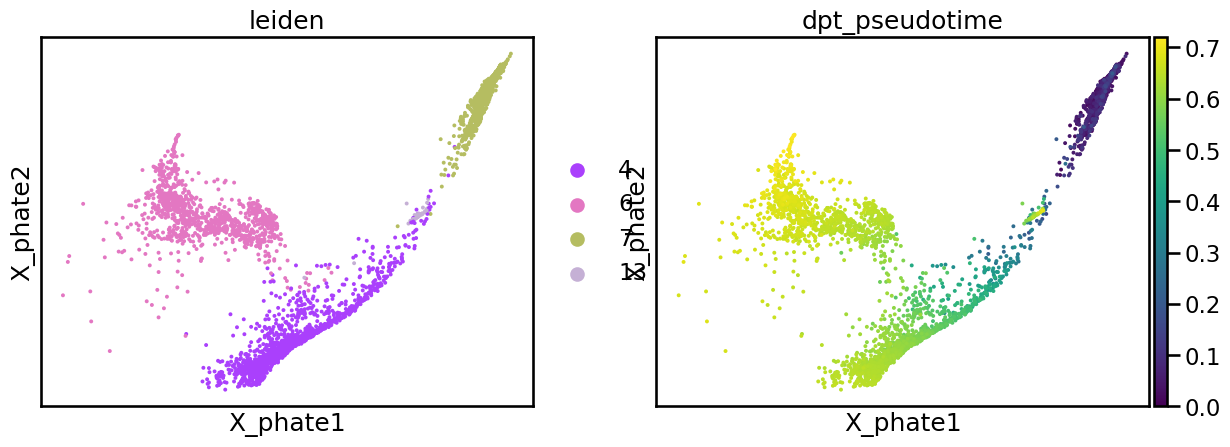

/tmp/ipykernel_555383/2483328669.py:3: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata_eb_original_endoderm.uns['iroot'] = np.flatnonzero(adata_eb_original_endoderm.obs['leiden']  == '7')[0]
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [55]:
adata_eb_original_endoderm = adata_eb_original[adata_eb_original.obs.leiden.isin(['7', '13', '4', '6'])]
sc.pl.embedding(adata_eb_original_endoderm, basis="X_phate", color=["leiden", "dpt_pseudotime"])
adata_eb_original_endoderm.uns['iroot'] = np.flatnonzero(adata_eb_original_endoderm.obs['leiden']  == '7')[0]
sc.tl.dpt(adata_eb_original_endoderm)
adata_eb_original_endoderm = adata_eb_original_endoderm[adata_eb_original_endoderm.obs.sort_values(by="dpt_pseudotime").index]

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


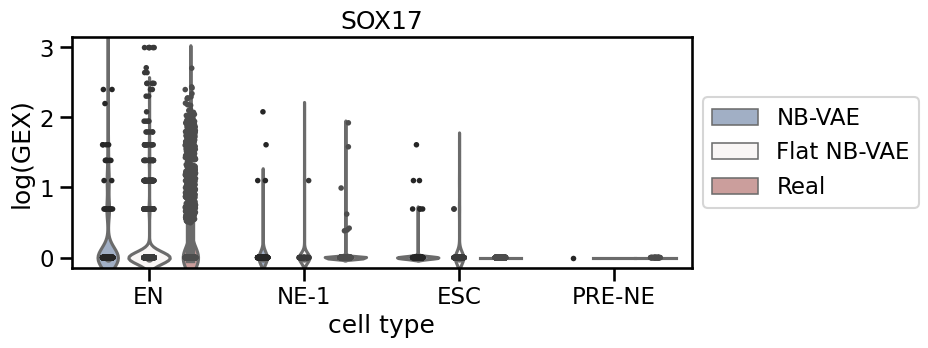

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


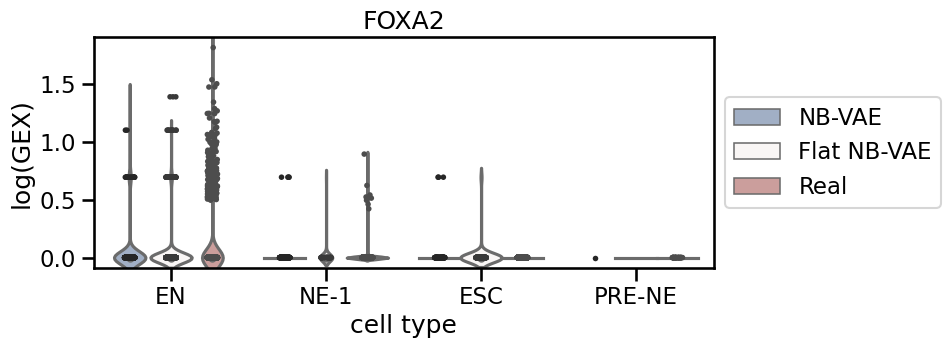

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


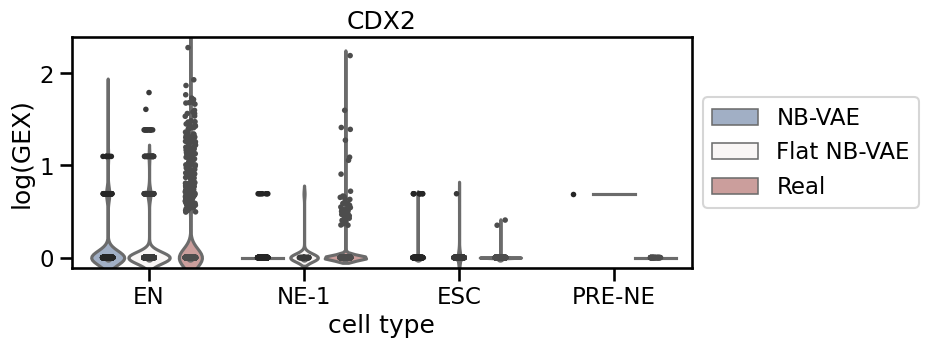

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/seaborn/categorical.py:166: FutureWarning: Setting a gradient palette using color= is deprecated and will be removed in version 0.13. Set `palette='dark:.3'` for same effect.
  warnings.warn(msg, FutureWarning)


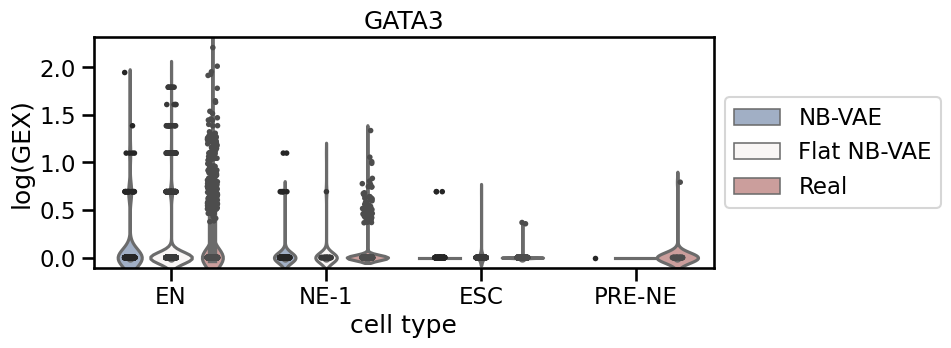

In [56]:
for gene, gene_id in genes_endoderm_cells.items():
    plot_violin_condition([X_endoderm_flat_ct, X_endoderm_vae_ct, adata_eb_original_endoderm],
                            gene, 
                            gene_id,
                            methods=["Flat NB-VAE", "NB-VAE", "Real"])

## Plot lineage drivers 

In [57]:
sc.set_figure_params(scanpy=True,
                         dpi=120, 
                         dpi_save=150,
                         frameon=False, 
                         vector_friendly=True,
                         fontsize=14, 
                         figsize=None,
                         color_map=None, 
                         format='pdf', 
                         facecolor=None, 
                         transparent=False, 
                         ipython_format='png2x')

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/scanpy/_settings.py:450: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [58]:
adata_x_traj_flat.var = adata_x_traj_flat.var.set_index("gene_name")       
adata_x_traj_vae.var = adata_x_traj_vae.var.set_index("gene_name")

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)
/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


Neural Crest drivers

In [59]:
adata_eb_original_neural_crest.var = adata_eb_original_neural_crest.var.set_index("gene_name")

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [60]:
adata_x_traj_flat_neural_crest = adata_x_traj_flat[adata_x_traj_flat.obs.leiden.isin(['7', '4', '8', '3'])]
adata_x_traj_vae_neural_crest = adata_x_traj_vae[adata_x_traj_vae.obs.leiden.isin(['7', '4', '8', '3'])]

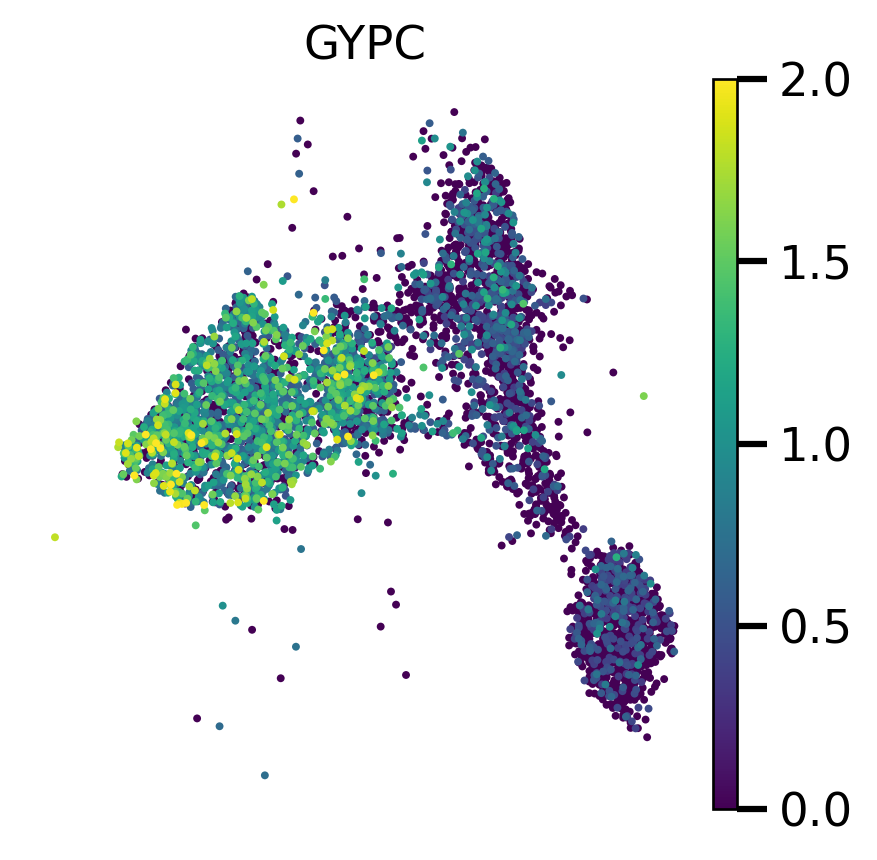

In [61]:
sc.pl.umap(adata_eb_original_neural_crest, color="GYPC", vmin=0, vmax=2)

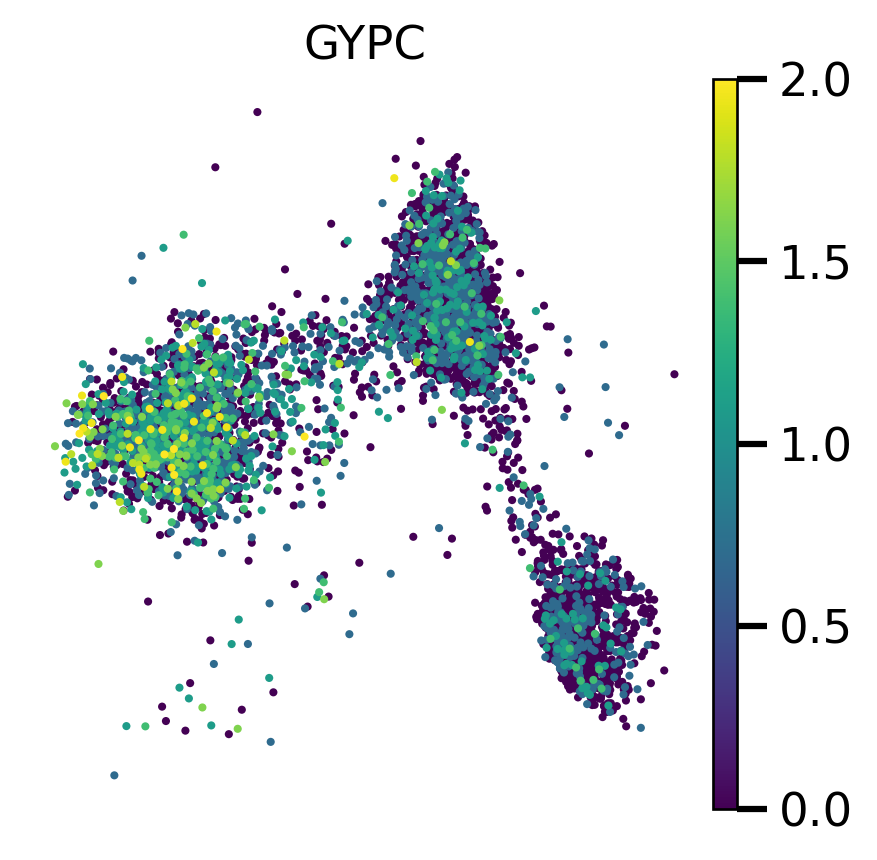

In [62]:
sc.pl.umap(adata_x_traj_flat_neural_crest, color="GYPC", vmin=0, vmax=2)

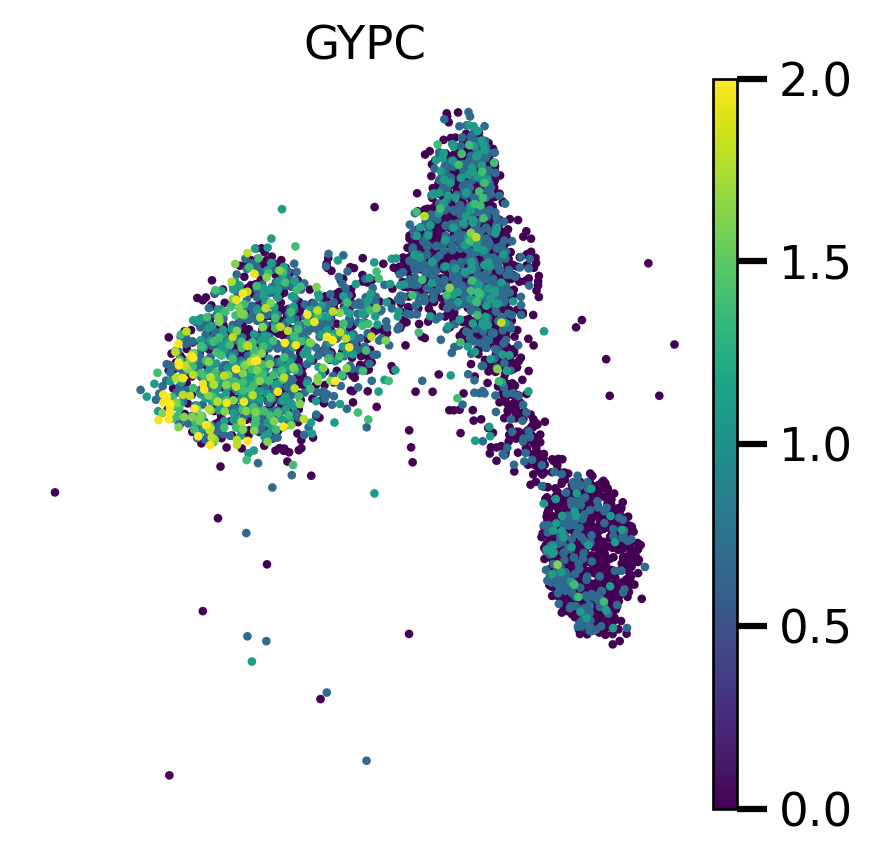

In [63]:
sc.pl.umap(adata_x_traj_vae_neural_crest, color="GYPC", vmin=0, vmax=2)

Cardiac drivers

In [64]:
adata_eb_original_cardiac.var = adata_eb_original_cardiac.var.set_index("gene_name")

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [65]:
adata_x_traj_flat_cardiac = adata_x_traj_flat[adata_x_traj_flat.obs.leiden.isin(['7', '9', '2', '5'])]
adata_x_traj_vae_cardiac = adata_x_traj_vae[adata_x_traj_vae.obs.leiden.isin(['7', '9', '2', '5'])]

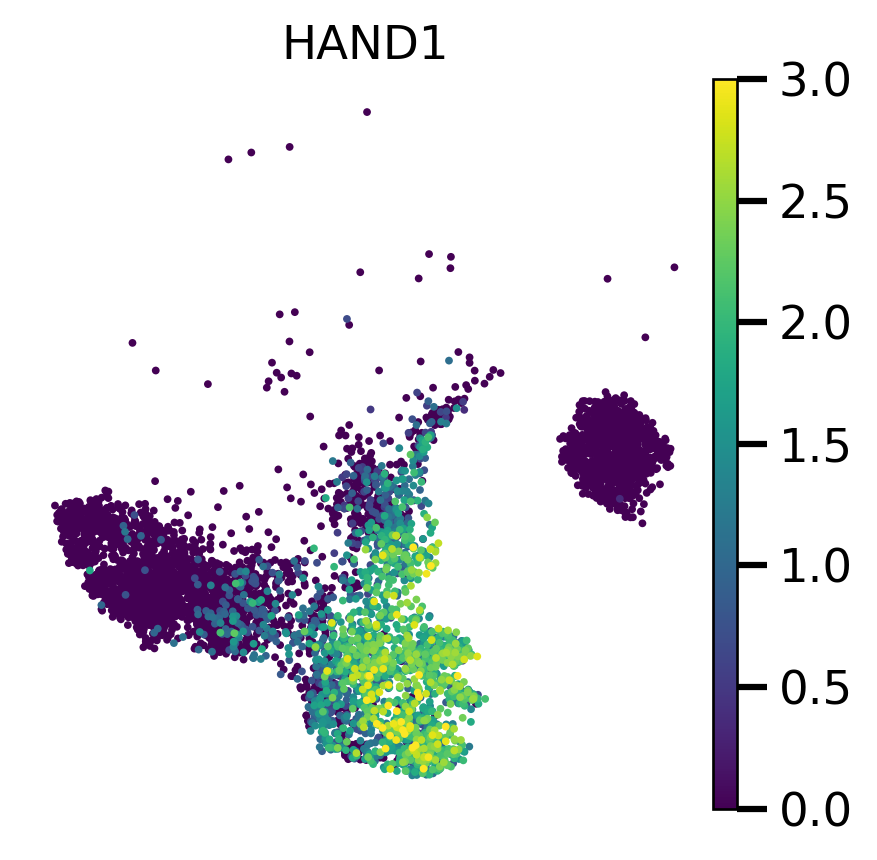

In [66]:
sc.pl.umap(adata_eb_original_cardiac, color="HAND1", vmin=0, vmax=3)

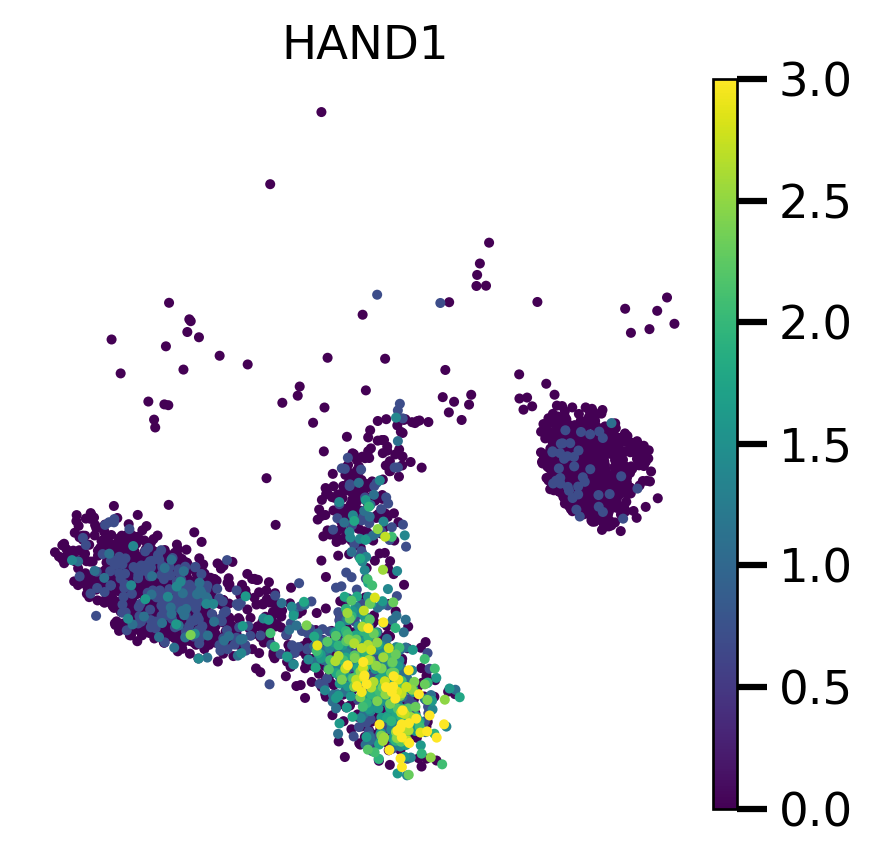

In [67]:
sc.pl.umap(adata_x_traj_flat_cardiac, color="HAND1", vmin=0, vmax=3)

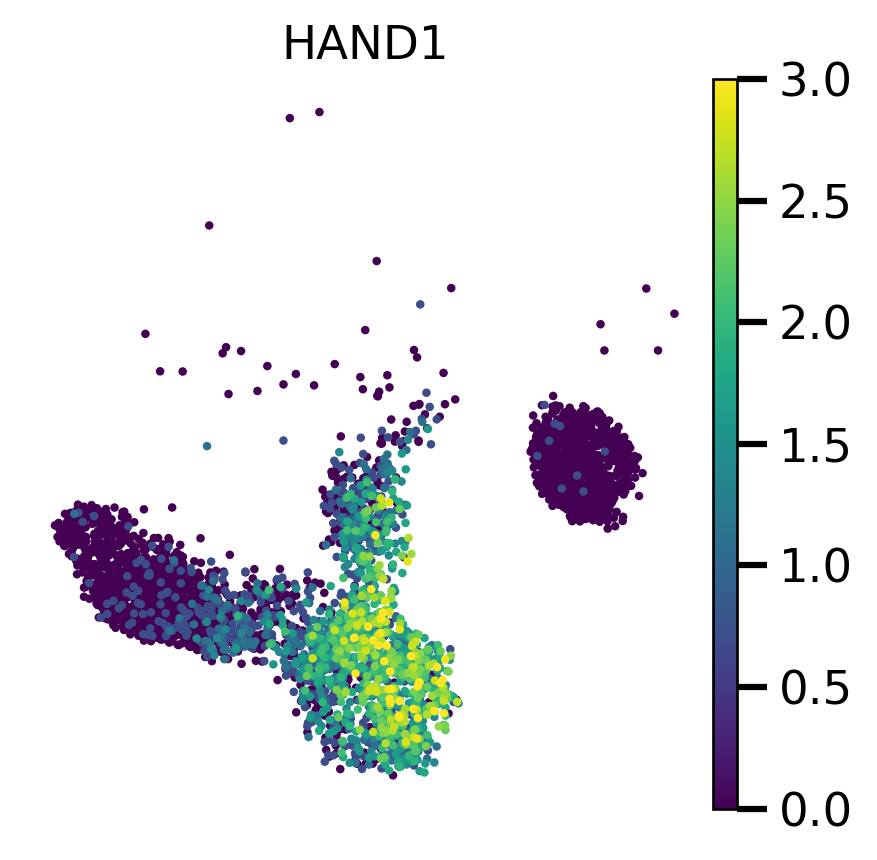

In [68]:
sc.pl.umap(adata_x_traj_vae_cardiac, color="HAND1", vmin=0, vmax=3)

Neural drivers

In [69]:
adata_eb_original_neuronal.var = adata_eb_original_neuronal.var.set_index("gene_name")

/nfs/staff-ssd/pala/miniconda3/envs/scCFM/lib/python3.10/site-packages/anndata/_core/anndata.py:788: UserWarning: 
AnnData expects .var.index to contain strings, but got values like:
    ['ABAT', 'ABHD14B', 'AC007325.4', 'AC009501.4', 'ACAT2']

    Inferred to be: categorical

  value_idx = self._prep_dim_index(value.index, attr)


In [70]:
adata_x_traj_flat_neuronal = adata_x_traj_flat[adata_x_traj_flat.obs.leiden.isin(['7', '4', '1', '10'])]
adata_x_traj_vae_neuronal = adata_x_traj_vae[adata_x_traj_vae.obs.leiden.isin(['7', '4', '1', '10'])]

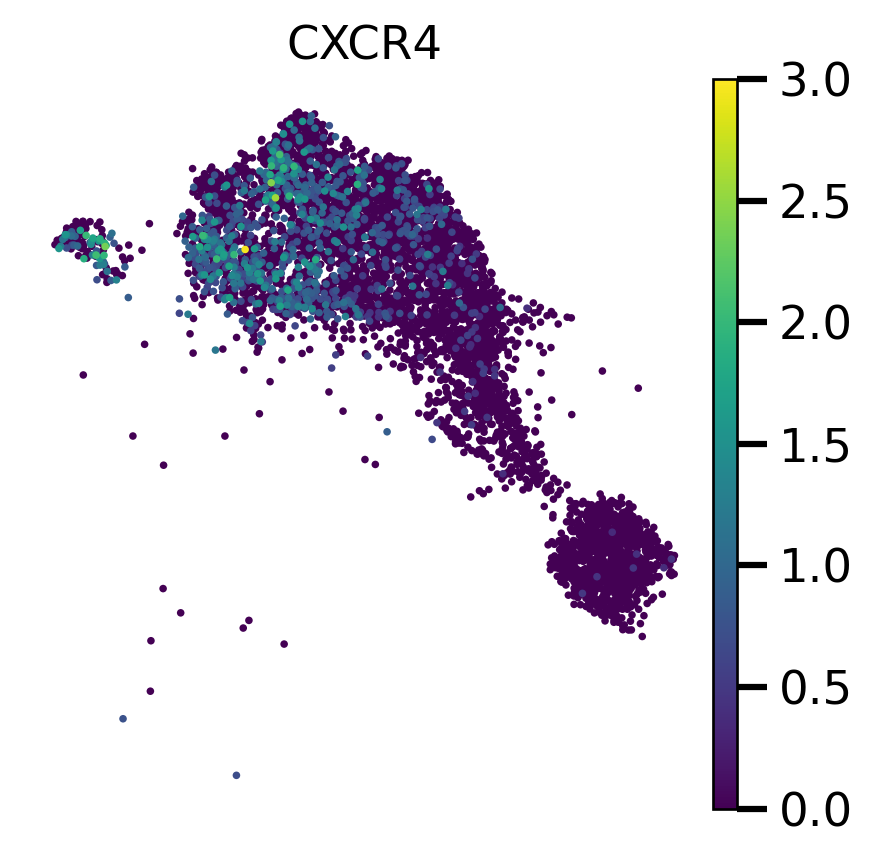

In [71]:
sc.pl.umap(adata_eb_original_neuronal, color="CXCR4", vmin=0, vmax=3)

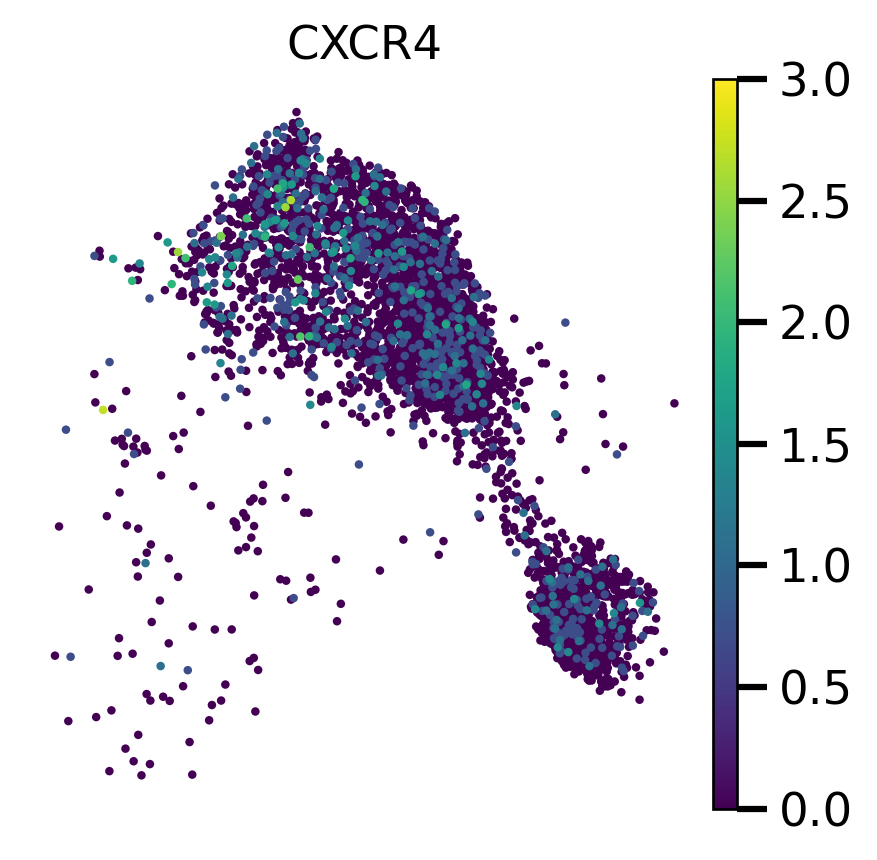

In [72]:
sc.pl.umap(adata_x_traj_flat_neuronal, color="CXCR4", vmin=0, vmax=3)

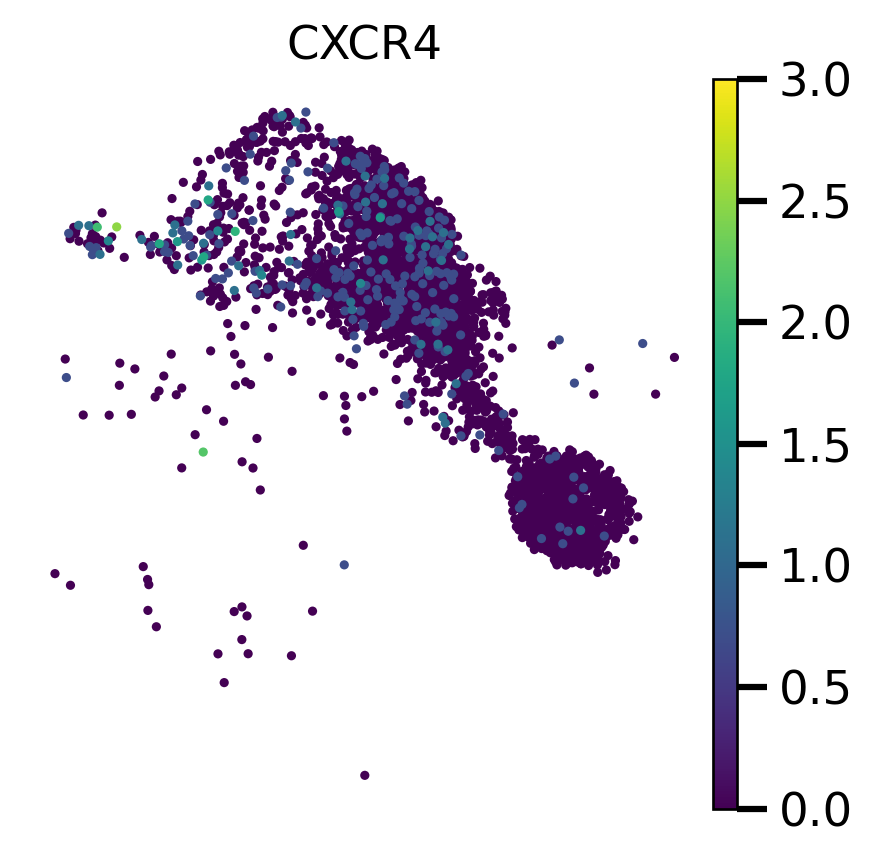

In [74]:
sc.pl.umap(adata_x_traj_vae_neuronal, color="CXCR4", vmin=0, vmax=3)